In [ ]:
from google.colab import drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#Ruta raiz
PATH = "/content/drive/MyDrive/MachineLearning/pix2Pix"

#Ruta de inputs
inPATH = PATH + "/inputFlowers"

#Ruta de targets
tarPATH = PATH + "/targetFlowers"

#Ruta de los checkpoints

ckPATH = PATH + "/checkPoints"

#Para listar el contenido
imgurls = !ls -1 "{inPATH}"






Para eliminar el overfitting puesto que las flores siguien un orden.

In [ ]:
#500 imagenes
n = 500

#Data set del 80% del numero de flores
train_n = round(n*0.80)

#Listado randomizado
randurls = np.copy(imgurls)


np.random.shuffle(randurls)

#Particion train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

8189 400 100


Sabiendo que la api que utilizamos nos va a pedir que añadamos las funciones del preprocesamiento para las imagenes 

image_05454.jpg


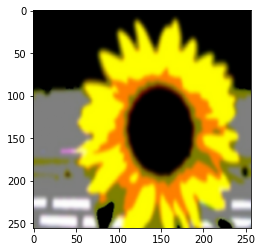

In [ ]:

IMG_WIDTH = 256
IMG_HEIGHT = 256

#Reescalar imgagenes
def resize(inimg,tgimg,height,width):
    
  inimg=tf.image.resize(inimg,[height,width])
  tgimg=tf.image.resize(tgimg,[height,width])
  
  return inimg,tgimg


#Normalizamos al rango [-1,+1] la imagen
def normalize(inimg,tgimg):
  inimg=(inimg/ 127.5) - 1
  tgimg=(tgimg/ 127.5) - 1

  return inimg,tgimg

#Aparece en el paper https://phillipi.github.io/pix2pix/
#Aumenzaticion de los datos: Random Crop + Flip. con esto generamos más imagenes que crearan un mejor dataset
@tf.function() #Ayuda a la optimizacion
def random_jitter(inimg, tgimg):
  
  inimg, tgimg = resize(inimg, tgimg, 286, 286)
  
  #Apilamos las dos imagenes, puesto que necesitamos que los cambios sean iguales en ambas imagenes
  stacked_image = tf.stack([inimg,tgimg], axis=0)

  #Hace el recorte aleatorio. El 3 por RGB
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH,3])

  inimg,tgimg = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5: #Moneda al aire
  
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  
  return inimg, tgimg

#Cargara la imagenes
def load_image (filename, augment=True):
  #Los castamos al float para las futuras operaciones como la normalizacion. Nos aseguramos que tengan 3 dimensiones puesto que si es png tiene alfa
  print(filename)
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(inPATH + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(tarPATH + '/' + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg


def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename,False)


plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)




Creamos los generadores


In [ ]:
#Crea un dataset a partir de unos elementos dados
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#Para crear lotes de imagenes
train_dataset = train_dataset.batch(1)

#Crea un dataset a partir de unos elementos dados
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#Para crear lotes de imagenes
test_dataset = test_dataset.batch(1)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


Para visializar los datos

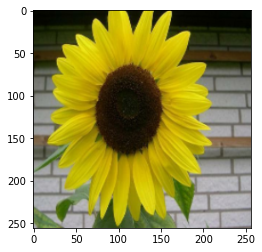

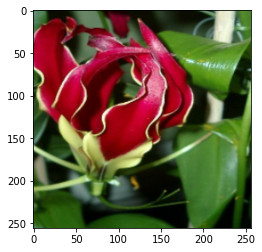

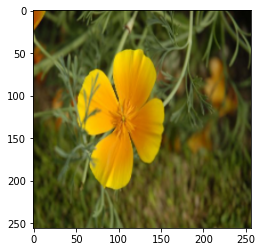

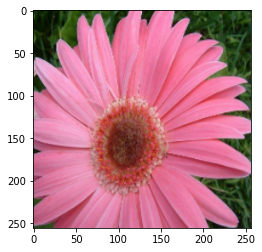

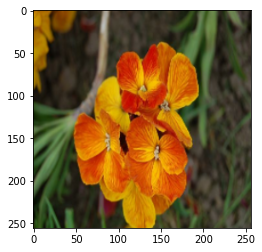

In [ ]:
for inimg, tgimg in train_dataset.take(5):
  plt.imshow(((tgimg[0,...]) + 1) / 2)
  plt.show()

Tras finalizar la parte de carga de datos comenzamos con la infraestructura Pix2Pix. Todo aparece en el Paper. https://www.tensorflow.org/tutorials/generative/pix2pix

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
#Bloque que va a represnentar las capas(Encoder)
def downsample(filters, apply_batchnorm=True):
  #Especificamos a Keras que viene una secuencia de capas
  result = Sequential()
  
  #Ruido Gausiano
  initializer = tf.random_normal_initializer(0,0.02)
  # Capa convolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,  #Nos reduce a la mitad
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))#Sesgo


  if apply_batchnorm:

    #Capa de BatchNorm
    result.add(BatchNormalization())

  #Capa de activacion
  result.add(LeakyReLU())

  return result

downsample(64)




In [ ]:
#Decoder
def upsample(filters, apply_dropout=False):
  #Especificamos a Keras que viene una secuencia de capas
  result = Sequential()
  
  #Ruido Gausiano
  initializer = tf.random_normal_initializer(0,0.02)
  # Capa convolucional
  result.add(Conv2DTranspose(filters,
                              kernel_size=4,
                              strides=2,  #Nos reduce a la mitad
                              padding="same",
                              kernel_initializer=initializer,
                              use_bias=False))#Sesgo


  #Capa de BatchNorm
  result.add(BatchNormalization())

  if apply_dropout:
    #Capa de Dropout. Desconecta conexiones ciertas conexiones de manera aleatoria que sirve como elemente regulador de la red
    result.add(Dropout(0.5))
  
  #Capa de activacion
  result.add(ReLU())

  return result

upsample(64)

#Arquitectuca UNET  Generador

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


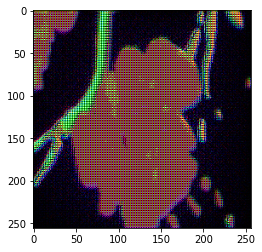

In [ ]:

def Generator():

  inputs = tf.keras.layers.Input(shape=[None, None, 3])

  down_stack = [
    downsample(64, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128),                        # (batch_size, 64, 64, 128)
    downsample(256),                        # (batch_size, 32, 32, 256)
    downsample(512),                        # (batch_size, 16, 16, 512)
    downsample(512),                        # (batch_size, 8, 8, 512)
    downsample(512),                        # (batch_size, 4, 4, 512)
    downsample(512),                        # (batch_size, 2, 2, 512)
    downsample(512),                        # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512),                      # (batch_size, 16, 16, 1024)
    upsample(256),                      # (batch_size, 32, 32, 512)
    upsample(128),                      # (batch_size, 64, 64, 256)
    upsample(64),                       # (batch_size, 128, 128, 128)
  ]


  initializer = tf.random_normal_initializer(0,0.02)

  last = Conv2DTranspose(filters=3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")

  x = inputs
  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x,sk])

  last = last(x)

  return Model(inputs=inputs, outputs=last)

generator = Generator()
gen_output = generator((inimg+1)*255,training = False)
plt.imshow(gen_output[0,...])

#Discriminador PATCHGAN

TensorShape([1, 16, 16, 1])

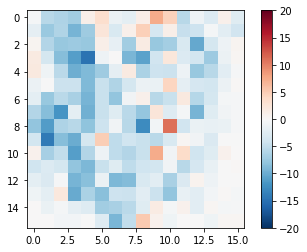

In [ ]:
def Discriminator():
  ini = Input(shape=[None, None,3], name="input_img")
  gen = Input(shape=[None, None,3], name="gener_img")

  con = concatenate([ini,gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)  
  down2 = downsample(128)(down1)  
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)    

  last = Conv2D(filters=1,#Un unico canald de informacion puesto que es es real o no
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)  

  return Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

disc_out = discriminator([((inimg+1)*255), gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
disc_out.shape

#Funcion de coste Adversaria

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss (disc_real_output, disc_generated_output):
  
  #Diferencia entre los true por ser real y el detectado por el discrimninador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  #Diferencia entre los false por ser generado y el detectado por el discrimninador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [ ]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [ ]:

import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#Para poder restaurar si colab se cae
checkpoint_prefix = os.path.join(ckPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#Para poder hacerlo ejecutar
#checkpoint.restore(tf.train.latest_checkpoint(ckPATH)).assert_consumed()

Evaluar el comportamiento del generador durante el entrenamiento

In [ ]:
def generate_images(model, test_input, tar,save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output/' + save_filename + '.jpg', prediction[0,...])
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)



    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))


In [ ]:
from IPython.display import clear_output

def train(dataset, epochs):

  for epoch in range(epochs):
    imgi = 0

    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)

    imgi = 0
   
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)
      imgi += 1
    #saving (checkpoint) the model every 20 epochs
    if(epoch + 1) % 25 == 0: 
      checkpoint.save(file_prefix = checkpoint_prefix)